# Assignment 2: P2P lending

Machine Learning for Finance  
VU Amsterdam    

**Instructors**  
Iman van Lelyveld (iman.van.lelyveld@vu.nl)<br/>
Dieter Wang (d.wang@vu.nl)  


**Authors**

Pedro Masi Godoy

Filipp Peresadilo

Lieke van Kampen



## Instructions
* This assignment covers the material discussed up to Lecture 6. 
* Each group submits _only one_ notebook via canvas on the assignment page. 
* The notebook should be named `assignment2_groupXX.ipynb` where `XX` is your group number,  
e.g. for group 3 this will be `assignment2_group03.ipynb`.
* The notebook should run without raising any errors. Our benchmark is whether it runs in Computer Lab 1G23.
* We recommend the folder structure

```
assignment/
-- data/
-- assignment2_groupXX.ipynb
```

* We strongly recommend git, as you are encouraged to collaborate and split up the work and maybe even start independently. 
* Do not spend time on optimizing the speed of your code. However, if it runs for more than 5 minutes, we will terminate it. 
* We strongly encourage you to experiment, try different approaches and combinations and get to know the problem from alternative angles. But the final notebook should only contain the necessary results for grading.



### About this assignment
* Different from the first assignment, this time we pay attention to the validation of our results. In other words, we are also interested in how well we do on data, the model has not seen. 

* Note that this assignment can become computationally heavy. If you run into computational bottlenecks, discuss with your group members if you can simplify the problem. If you're thinking about getting a cloud computing subscription to solve this assignment, you are heading in the wrong direction!
* The programming part is important but we put a larger weight weigh on your **explanation**.


## Introduction

Peer-to-peer lending has been booming in recent years. This platform industry matches borrowers and lenders to finance projects that might not have been possible otherwise. But this is a risky business. Some loans are long past their due date, some are cancelled, some are officially defaulted. In this assignment we look at the loan data from https://www.prosper.com and predict how likely a loans is to default and the probability of a member (=borrower) to default. 

This [blog](https://towardsdatascience.com/p2p-lending-platform-data-analysis-exploratory-data-analysis-in-r-part-1-32eb3f41ab16) uses the same data but has very different research agenda. Nonetheless, it could be useful if you want to learn more about it.

<img src="https://www.lendenclub.com/wp-content/uploads/2018/06/how-p2p-works.jpg" />

# Question 1
**5 points**

Load the following two files
* `prosper_data.csv` contains the full dataset with all members and loans. 
* `prosper_definitions.csv` contains variable descriptions. The column `Category` designates which variables are member- or loan-related.

**a)** Create a dataframe `df_member` for all member-related data with the column `MemberKey` as the index.

**b)** Create a dataframe `df_loans` for all loan-related data with the column `LoanKey` as the index.

**c)** Associate each member (`MemberKey`) with its loans (`LoanKey`). You can use a separate dictionary or a pandas series for this. Call this mapping `members2loans`

## Importing packages
We import all of the packages used in this assignment in the following code block.

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, precision_recall_curve, plot_confusion_matrix
from sklearn.tree import plot_tree # to draw a classification tree
import graphviz

## Answer

First, we import the definitions data. We use os.path.join() because it is platform-independent. After, we create two lists: one for the loan variable categories and the other for the member variable categories. Also, we import the actual data.

In [2]:
# import variable descriptions
path_def = os.path.join('data','prosper_definitions.csv')
definitions = pd.read_csv(path_def, index_col=[0])

# create list of loan-related categories
loan_cats = definitions[definitions['Category'] == 'loan'].Category.index.tolist()

# create list of member-related categories
member_cats = definitions[definitions['Category'] == 'member'].Category.index.tolist()

# import full dataset with members and laons
path = os.path.join('data','prosper_data.csv')
dataset = pd.read_csv(path, index_col=[0])

**Part A)**

Creating a dataframe df_member for all member-related data with the column MemberKey as the index.

In [3]:
# creating a dataframe df_member for all member-related data with the column MemberKey as the index
df_members = dataset[member_cats].set_index('MemberKey')

**Part B)**

Creating a dataframe df_loans for all loan-related data with the column LoanKey as the index.

In [4]:
# creating a dataframe df_loans for all loan-related data with the column LoanKey as the index.
df_loans = dataset[loan_cats].set_index('LoanKey')

**Part C)**

Associating each member (MemberKey) with its loans (LoanKey).

In [5]:
# associating each member (MemberKey) with its loans (LoanKey).
# members2loans = pd.Series(dataset.LoanKey.values,index=dataset.MemberKey).to_dict()

members2loans = dataset[['MemberKey', 'LoanKey']]

---

# Question 2
**10 points**

In this question you predict whether loans will default or not. Part of the data consists of current loans that are neither defaulted nor paid off. The remaining loans are completed. Separate the data into a two new dataframes `df_current_loans` and `df_completed_loans`. For the `df_completed_loans`, create a binary target series that is 
* `0` if the `LoanStatus` either has the value `Completed` or `FinalPaymentInProgress`,
* `1` otherwise,

and create a feature dataframe with the remaining, relevant features. 

Are any specific data preprocessing steps necessary? If so, describe what they are and how you resolve them. Use visual aids when helpful.

## Answer

For this part, we take nine elaborate steps to preprocess our data and carefully select relevant variables:
- Step 0: interpretation of the data
- Step 1: identifying data types to discover inconsistencies
- Step 2: describing the dataset
- Step 3: checking dataset for missing values
- Step 4: splitting the data
- Step 5: checking the distributions of data (with histograms)
- Step 6: Creating a correlation matrix
- Step 7: variable selection based on previous steps
- Step 8: imputing missing values

The result is that we have a good understanding of the data, we split the data, selected relevant variables with sound reasoning, and imputed missing values.

**Step 0: interpretation of the data**

First, we interpret it this way. Loans can be either:
- **Completed**, either defaulted (`Defaulted`, `Chargedoff`) or completed (`Completed`, `FinalPaymentInProgress`). "When a debt is charged off, it’s taken off the creditor’s balance sheet. This generally occurs when a payment is between 90 and 180 days past due. If no payment is made by this time, the creditor assumes that the debt is unlikely to be paid in the near future. Since the delinquent debt can’t be carried on the creditor’s books as a current asset, the creditor marks the debt as “charged off.” Thus, we assume it's basically defaulted.
- **Current** (`Current`, `Past Due (1-15 days)`, `Past Due (61-90 days)`, `Past Due (31-60 days)`, `Past Due (16-30 days)`, `Past Due (>120 days)`, `Past Due (91-120 days)`). Here we make the assumption that loans that are past their due date are still current.

**Step 1: identifying data types to discover inconsistencies**

In [6]:
# dtypes tell us the data type for each column
df_loans.dtypes

MonthlyLoanPayment               float64
PercentFunded                    float64
Term                               int64
LoanFirstDefaultedCycleNumber    float64
LoanMonthsSinceOrigination         int64
LoanOriginalAmount                 int64
InvestmentFromFriendsCount         int64
InvestmentFromFriendsAmount      float64
Investors                          int64
LoanStatus                        object
BorrowerAPR                      float64
BorrowerRate                     float64
LenderYield                      float64
EstimatedEffectiveYield          float64
EstimatedLoss                    float64
EstimatedReturn                  float64
dtype: object

**Observation**: data types seem to be alright. All variables, with the exception of `LoanStatus` are either *floats* or *ints*. The reason that `LoanStatus` is an *object* is that it is a categorical variable which we will later use to categorize our data, so there should not be a problem.

**Step 2: describe dataset**

In [7]:
df_loans.describe()

,MonthlyLoanPayment,PercentFunded,Term,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanOriginalAmount,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn
count,10000.000000,10000.000000,10000.000000,1533.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7436.000000,7436.000000,7436.000000
mean,271.850343,0.998573,40.864800,16.460535,31.788800,8335.081600,0.020100,13.649049,81.030200,0.219067,0.192978,0.182886,0.168392,0.080097,0.095855
std,188.982414,0.018355,10.500702,8.951161,30.090004,6196.603884,0.178603,260.140197,104.135958,0.080008,0.074582,0.074286,0.068075,0.046587,0.030249
min,0.000000,0.700500,12.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,1.000000,0.013150,0.000000,-0.010000,-0.181600,0.006000,-0.181600
25%,132.610000,1.000000,36.000000,10.000000,6.000000,4000.000000,0.000000,0.000000,2.000000,0.157130,0.134000,0.124000,0.115670,0.042400,0.074000
50%,220.110000,1.000000,36.000000,15.000000,20.000000,6500.000000,0.000000,0.000000,44.000000,0.209595,0.184000,0.173000,0.158670,0.069900,0.091670
75%,370.582500,1.000000,36.000000,22.000000,66.000000,12000.000000,0.000000,0.000000,116.000000,0.283200,0.250000,0.240000,0.223700,0.112000,0.115800
max,1563.210000,1.000000,60.000000,41.000000,97.000000,35000.000000,6.000000,15000.000000,1035.000000,0.413550,0.360000,0.352500,0.319900,0.366000,0.227700


**Observation:** here we see the first potential problem! The dataset consists of 10,000 datapoints (see count values). However, for some values we see count values that are less than that, indicating that there might be missing values.

**Step 3: checking for missing values**

In [8]:
df_loans.isna().sum()

MonthlyLoanPayment                  0
PercentFunded                       0
Term                                0
LoanFirstDefaultedCycleNumber    8467
LoanMonthsSinceOrigination          0
LoanOriginalAmount                  0
InvestmentFromFriendsCount          0
InvestmentFromFriendsAmount         0
Investors                           0
LoanStatus                          0
BorrowerAPR                         0
BorrowerRate                        0
LenderYield                         0
EstimatedEffectiveYield          2564
EstimatedLoss                    2564
EstimatedReturn                  2564
dtype: int64

**Observation:**

We observe the following issues:
- First, `LoanFirstDefaultedCycleNumber` is missing in 8,467 data points. This means that this value is missing in 84.67% of our dataset. However, when we check the definitions file, it says the following about this variable: "LoanFirstDefaultedCycleNumber - The cycle the loan was charged off. If the loan has not charged off the value will be null." This explains a lot. A loan that is not charged of, will logically miss this value. An important implication that flows from this finding is that we cannot use this variable to predict whether a loan will default or charged off.
- Second, `EstimatedEffectiveYield`, `EstimatedLoss`, `EstimatedReturn` are missing in 2,564 data points (or 25.64% of our data set). After careful research of the definition file we see that these values are only available for loans originated after July 2009. These missing values are thus logically explained.

**Step 4: splitting the data**

We split the data in:
- `df_current_loans`
- `df_completed_loans`,  either `default =1` (`Defaulted`, `Chargedoff`) or `default=0` (`Completed`, `FinalPaymentInProgress`).

In [9]:
# Creating the completed loans dataframe, and creating a binary target series
df_completed_loans = df_loans[df_loans['LoanStatus'].isin(['Completed', 'FinalPaymentInProgress', 'Defaulted', 'Chargedoff'])]
df_completed_loans['default'] = np.where(df_completed_loans['LoanStatus'].isin(['Completed', 'FinalPaymentInProgress']), 0, 1)

# Creating the current loans dataframe
df_current_loans = df_loans[~df_loans['LoanStatus'].isin(['Completed', 'FinalPaymentInProgress', 'Defaulted', 'Chargedoff'])]

C:\Users\Filipp\Anaconda3\envs\VU Finance\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**Step 5: checking the distributions of data (with histograms)**

We do this with our train dataset in order to identify variables that will not add any value in our models. In this step we check for variables that do stay the same across the whole train dataset (i.e. that have variance of zero). These variables will not help us in our classifiction task. 

array([[<AxesSubplot:title={'center':'MonthlyLoanPayment'}>,
        <AxesSubplot:title={'center':'PercentFunded'}>,
        <AxesSubplot:title={'center':'Term'}>,
        <AxesSubplot:title={'center':'LoanFirstDefaultedCycleNumber'}>],
       [<AxesSubplot:title={'center':'LoanMonthsSinceOrigination'}>,
        <AxesSubplot:title={'center':'LoanOriginalAmount'}>,
        <AxesSubplot:title={'center':'InvestmentFromFriendsCount'}>,
        <AxesSubplot:title={'center':'InvestmentFromFriendsAmount'}>],
       [<AxesSubplot:title={'center':'Investors'}>,
        <AxesSubplot:title={'center':'BorrowerAPR'}>,
        <AxesSubplot:title={'center':'BorrowerRate'}>,
        <AxesSubplot:title={'center':'LenderYield'}>],
       [<AxesSubplot:title={'center':'EstimatedEffectiveYield'}>,
        <AxesSubplot:title={'center':'EstimatedLoss'}>,
        <AxesSubplot:title={'center':'EstimatedReturn'}>,
        <AxesSubplot:title={'center':'default'}>]], dtype=object)

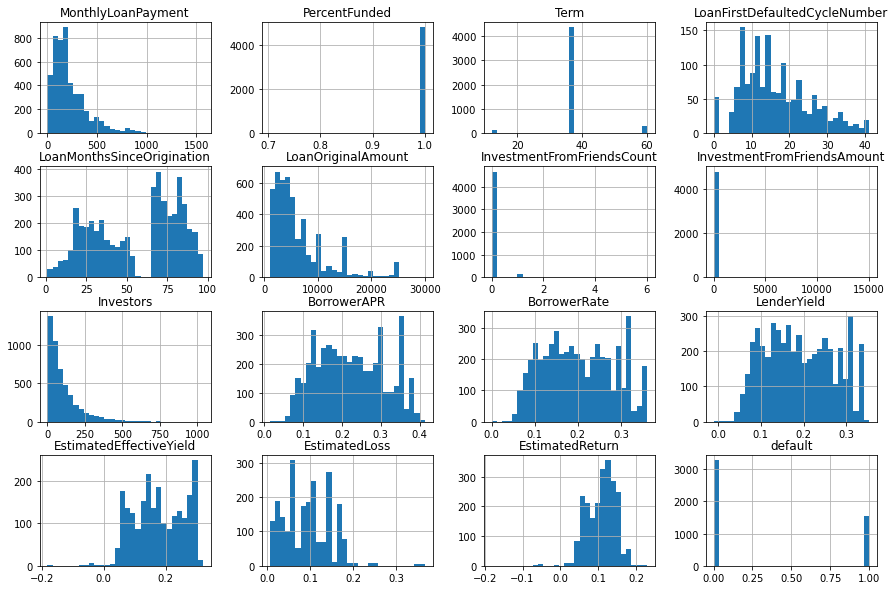

In [10]:
df_completed_loans.hist(bins=30, figsize=(15, 10))

**Interpretation:** `PercentFunded` is always 1 and `InvestmentFromFriendsAmount` is always 0 om our dataset, so these variables have no value in our models when they're always the same.

**Step 6: Create a correlation matrix**

We create a correlation matrix in order to check whether we have cases of (near) perfect collinearity. If variables are (near) perfectly correlated with each other it does not make sense to include them both.

<AxesSubplot:>

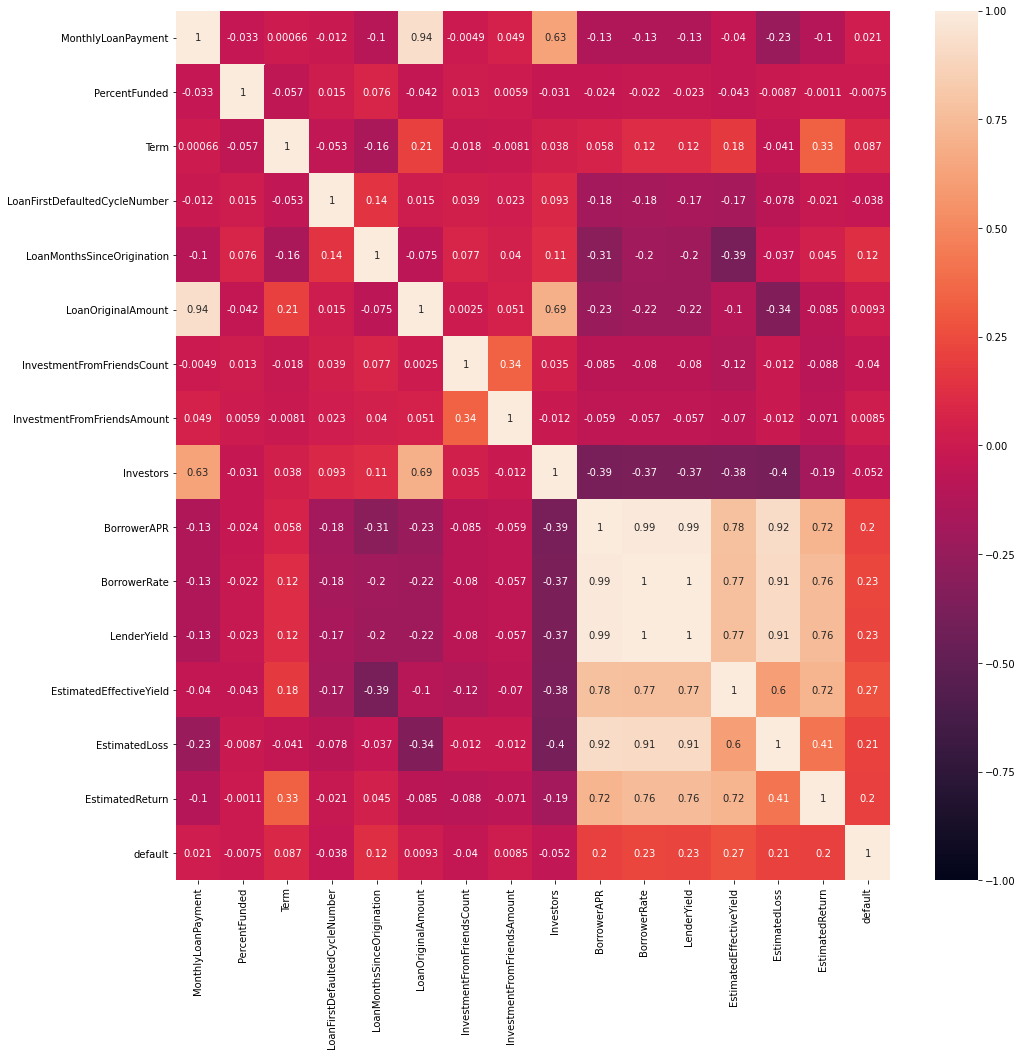

In [11]:
fig = plt.figure(figsize=[16,16])
sns.heatmap(df_completed_loans.corr(), annot=True, vmin=-1, vmax=1)

**Interpretation**
- `BorrowerAPR`, `BorrowerRate` and `LenderYield` have near perfect collinearity. It doesn't make sense to include all three, so we have to chose one. Let's go for `BorrowerRate`.
- `LoanOriginalAmount` and `MonthlyLoanPayment` have near perfect collinearity. Which makes sense; the higher the loan, the higher the monthly payment. It doens't make sense to include them both, so we have to chose one. Let's go for MonthlyLoanPayment.

**Conclusion**
We remove the following features from our feature set:
- `PercentFunded`
- `InvestmentFromFriendsAmount`
- `BorrowerAPR`
- `LenderYield`
- `LoanOriginalAmount`

In [12]:
loan_cats

['MonthlyLoanPayment',
 'PercentFunded',
 'Term',
 'LoanKey',
 'LoanFirstDefaultedCycleNumber',
 'LoanMonthsSinceOrigination',
 'LoanOriginalAmount',
 'InvestmentFromFriendsCount',
 'InvestmentFromFriendsAmount',
 'Investors',
 'LoanStatus',
 'BorrowerAPR',
 'BorrowerRate',
 'LenderYield',
 'EstimatedEffectiveYield',
 'EstimatedLoss',
 'EstimatedReturn']

**Step 7: variable selection**

We have decided to remove the following features from our dataset:
- `LoanFirstDefaultedCycleNumber`, because obviously the availability of this data is a perfectly correlated with defaults (charge offs), but this data is only available after the default, so it has not predictive power.
- `PercentFunded` and `InvestmentFromFriendsAmount`, because this variable is a constant in our train set, thus zero predictive power.
- `BorrowerAPR` and `LenderYield`, because these variables are (near) perfectly correlated with `'BorrowerRate`.
- `LoanKey`, this is just a unique loan identification number, so it has no economic predictive power. Any correlation would be coincidence (i.e. noise), so we remove this variable too.

We end up with the following feature set:

In [13]:
features = ['MonthlyLoanPayment',
             'Term',
             'LoanMonthsSinceOrigination',
             'InvestmentFromFriendsCount',
             'Investors',
             'BorrowerRate',
             'EstimatedEffectiveYield',
             'EstimatedLoss',
             'EstimatedReturn']

**Step 8: imputing missing values**
    
There is one step left in the construction of our dataset. As we have discovered in step 3, the values for `EstimatedEffectiveYield`, `EstimatedLoss`, `EstimatedReturn` are missing in 25.64% of our dataset because of a data availability issue described in the definitions overview. If it were just a few cases, we would just remove these cases from our dataset, but the missing values are too many. Deleting 25.64% of our data would not be a good decision. Therefore, we have decided to impute our missing values using a built-in imputer from SKLearn.

In [14]:
df_completed_loans[features + ['default']].isna().sum()

MonthlyLoanPayment               0
Term                             0
LoanMonthsSinceOrigination       0
InvestmentFromFriendsCount       0
Investors                        0
BorrowerRate                     0
EstimatedEffectiveYield       2564
EstimatedLoss                 2564
EstimatedReturn               2564
default                          0
dtype: int64

In [15]:
# initialize sklearn imputer
# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = KNNImputer(n_neighbors=10, weights="uniform")

df_completed_loans_imp = pd.DataFrame(imputer.fit_transform(df_completed_loans[features + ['default']]))

# impute values based on mean of variables
# df_completed_loans_imp_default = pd.DataFrame(imp_mean.fit_transform(df_completed_loans[df_completed_loans['default'] == 1][features + ['default']]))
# df_completed_loans_imp_nondefault = pd.DataFrame(imp_mean.fit_transform(df_completed_loans[df_completed_loans['default'] == 0][features + ['default']]))

In [16]:
# Reset dataframe with correct column and index values
df_completed_loans_imp.columns = df_completed_loans[features + ['default']].columns
df_completed_loans_imp.index = df_completed_loans[features + ['default']].index

**Bam!** We have imputed our variables!

In [17]:
df_completed_loans_imp.head()

,MonthlyLoanPayment,Term,LoanMonthsSinceOrigination,InvestmentFromFriendsCount,Investors,BorrowerRate,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,default
LoanKey,,,,,,,,,,
38CA3657598275440F97E9E,173.71,36.0,20.0,0.0,38.0,0.3177,0.28960,0.16500,0.12460,0.0
DC42341669824380161D870,335.50,36.0,72.0,0.0,193.0,0.1270,0.14627,0.09015,0.12882,0.0
77103378219174669128590,954.50,36.0,86.0,0.0,396.0,0.2198,0.11626,0.04597,0.07029,1.0
EDFA33643259614550B8BA9,106.96,36.0,91.0,0.0,27.0,0.1700,0.15666,0.14980,0.15666,0.0
71263638838686148D8C2D8,114.83,60.0,26.0,0.0,76.0,0.2151,0.20150,0.05950,0.14200,0.0


No missing values anymore!

In [18]:
df_completed_loans_imp.isna().sum()

MonthlyLoanPayment            0
Term                          0
LoanMonthsSinceOrigination    0
InvestmentFromFriendsCount    0
Investors                     0
BorrowerRate                  0
EstimatedEffectiveYield       0
EstimatedLoss                 0
EstimatedReturn               0
default                       0
dtype: int64

---

#  Question 3
**20 points**

<b>a)</b>
Split the targets and features you created based on `df_completed_loans` into 60% training data and 40% testing data. Fit a `LogisticRegression` to the training data. Which are the two most predictive features?

<b>b)</b>
Make predictions for the testing data and evaluate how well you do with a classification report.

<b>c)</b>
Finally, recall that the logistic regression actually produces a probability (or a score). This is then used by `LogisticRegression` to produce a binary classification, if it crosses a certain threshold. Examine graphically how well the classifier does if you vary that threshold. How would you summarizes this graph into one number?

## Answer

**Part A)**

As we have seen in the histogram of the y-variable (`default`) is not balanced. There are less defaults than non-defaults. We want to incorporate this inbalance in our test/train-split too, so we use a stratified split.

In [19]:
# Split train/test set with the sklearn built-in train_test_split method, using randomstate=42 for replicability (42 because it is the answer to everyting)
X_train, X_test, y_train, y_test = train_test_split(df_completed_loans_imp[features], 
df_completed_loans_imp['default'], test_size=0.4, stratify=df_completed_loans_imp['default'], random_state=42)

We assume from the question that we use a vanilla logistic regression, without any penalty (L1 or L2). In order to calculate our feature importance, we scale/normalize our variables.

Text(0.5, 0, 'Relative Feature Importance')

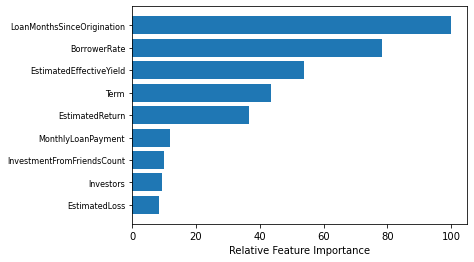

In [20]:
# We scale our data with the sklearn built-in scaler
scaler = StandardScaler()
scaler.fit(X_train) 
X_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)

# Initializing our logistic regression model with scaled X variables, we don't need to scale y since it's binary
logRes = LogisticRegression(random_state = 42, penalty='none')
logRes.fit(X_scaled, y_train)

# Calculate feature importance by transforming to relative positive values
feature_importance = abs(logRes.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# Sort them for a neat visualisation
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

# Generate visualisation of feature importance
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, feature_importance[sorted_idx], align='center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
ax.set_xlabel('Relative Feature Importance')

**Observation:** The two most predictive features are `BorrowerRate` and `LoanMonthsSinceOrigination`.

**Answer B)**

We re-run the regression, and construct a confusion matrix and a classification report. 

In [21]:
logRes = LogisticRegression(random_state = 42, penalty='none')
logRes.fit(X_train, y_train)
y_pred = logRes.predict(X_test)

In [22]:
confusion_matrix(y_test, y_pred)

array([[1235,   78],
       [ 486,  127]], dtype=int64)

**Observation:** In the confusion matrix, we see that of the 1235 + 78 = 1,313 non-defaults, 1,235 (94.06%) were correctly classified. And of the 486 + 127 = 613 defaults, 127 (20.72%) were correctly classified. 

In [23]:
target_names = ['Non-default', 'Default']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Non-default       0.72      0.94      0.81      1313
     Default       0.62      0.21      0.31       613

    accuracy                           0.71      1926
   macro avg       0.67      0.57      0.56      1926
weighted avg       0.69      0.71      0.65      1926



**Observation:**
- For the non-defaults we have a precision of 72%, a recall of 94% and a F1-score* of 81%.
- For the defaults we have a precistion of 62%, a recall of 21% and a F1-score* of 31%.

We could definitely do better than this!

\**The F1-score is the harmonic mean of the precision and recall.*

**Answer C)**

(0.0, 1.0)

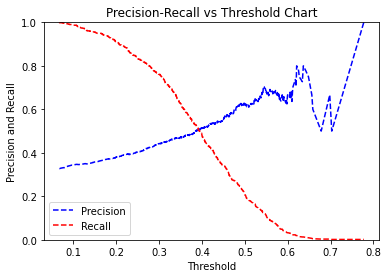

In [24]:
# Initialize logistic regression model again, only this time we use .predict_proba() to get the probability values
pred_y= logRes.predict(X_test) 
probs_y = logRes.predict_proba(X_test) 

# Apply the precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 1]) 
pr_auc = auc(recall, precision)

# Graph the precision/recall on the y-axis, and the treshold on the x-axis 
plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision and Recall")
plt.xlabel("Threshold")
plt.legend()
plt.ylim([0,1])

**Observations:** the best threshold point that we will use is around .39. However, it is important to realize that empirically this point might not give the highest prediction in the model with our current data, but this treshold would not be biased towards negative or positive values.

---

# Question 4
**20 points**

Use the full `df_completed_loans` data again. Import `DecisionTreeClassifier` and `cross_validate` from the sklearn library. Decision trees (DT) are a powerful way to classify data by growing more and more detailed branches. However, this can lead to overfitting where the DT essentially memorizes the data. Several ways exist to prevent the tree from growing too large. 

<b>a)</b> How can you prevent overfitting? Decide for one method and explain how you plan to determine the optimal size of a tree. 

<b>b)</b> Show a figure that relates prediction performance (y-axis) to tree size (x-axis). What is the optimal tree size?


**Hints** 
* Recall that there are different types of cross validators. Which one is most appropriate for this exercise?
* Carefully read the documentation of `cross_validate`. It may save you a lot of work.

## Answer

**Part A)**

We can prevent overfitting by adjusting the parameters of the initialization of the decision tree. However, we can simplify the process by pruning a tree by chosing an ideal `alpha` parameter by **cost complexity pruning** using **cross-validation**. With this method we essentially penalize the decision tree model for becoming to big (and thus prune, i.e. cut some of the leaves of the tree). This will be our preferred method to prevent overfitting.

In [25]:
# We do not use a train/test split anymore in this question
X = df_completed_loans_imp[features] 
y = df_completed_loans_imp['default']

In [26]:
# Initialize and fit the DT model on the data
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X, y)

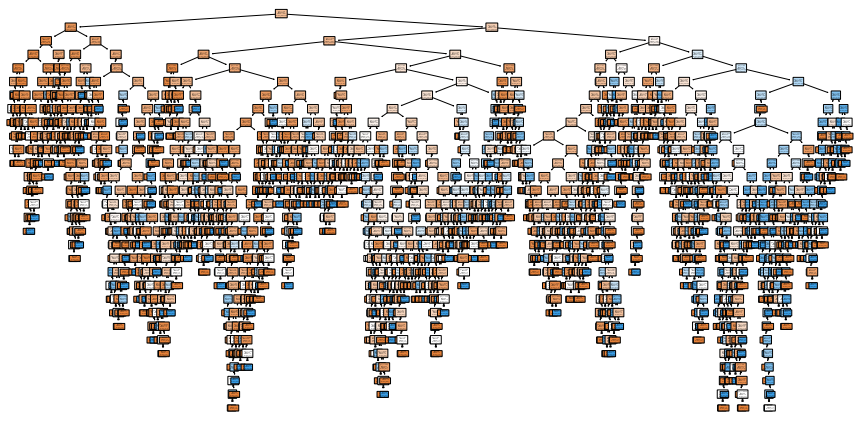

In [27]:
# Visualising the tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, filled=True, rounded=True, class_names=["Non-default", "Default"]); 

**Observation:** Jesus christ, it's huge. How are we ever going to explain such a model to the credit risk department of a bank? We have got some pruning to do. As indicated before, we will use cross-validation with cost complexity pruning.

In [28]:
# As indicated, we will use cos_complexity_pruning to determine alphas
path = clf_dt.cost_complexity_pruning_path(X, y) 
ccp_alphas = path.ccp_alphas[:-1] 

<AxesSubplot:xlabel='alpha'>

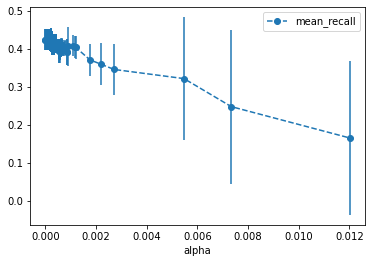

In [29]:
# Create a list to store results of every iteration/fold in cross-validation
alpha_loop_values = []

# For every value of alpha, we will run a 5-fold cross validation and store the accuracy scores in the list we just created
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    # Use precision in our case because we want to correctly predict defaults
    scores = cross_validate(clf_dt, X, y, cv=5, scoring=('f1'))['test_score']
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)]) # calculate mean and std of accuracy scores

# Creating a graph: alpha on x-axis, mean accuracy scores on y-axis (with distribution)
alpha_results = pd.DataFrame(alpha_loop_values, 
                             columns=['alpha', 'mean_recall', 'std'])
alpha_results.plot(x='alpha', y='mean_recall', yerr='std', marker='o', linestyle='--')

**Observation:** we have calculated the ideal alpha to prune our tree using cost complexity pruning with cross-validation. In our case it is zero.

**Part B)** Show a figure that relates prediction performance (y-axis) to tree size (x-axis). What is the optimal tree size?

Actually, when we operationalize "tree size" with our alpha, we actually have created a figure that relates prediction performance to tree size in our figure above. However, for the sake of completeness, we generate a plot that relates actual tree size (depth) with the average performance in our cross-validation (10 folds).

In [30]:
max_depth_loop_values = []

for i in range(1,50):
    clf_dt = DecisionTreeClassifier(random_state=42, max_depth=i, ccp_alpha=0.0)
    scores = cross_validate(clf_dt, X, y, cv=5, scoring=('f1'))['test_score']
    max_depth_loop_values.append([int(i), np.mean(scores), np.std(scores)]) # calculate mean and std of accuracy scores

<AxesSubplot:xlabel='max_depth'>

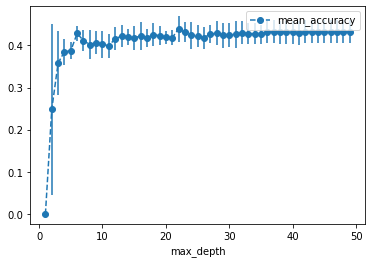

In [31]:
# Creating a graph: alpha on x-axis, mean accuracy scores on y-axis (with distribution)
max_depth_results = pd.DataFrame(max_depth_loop_values, columns=['max_depth', 'mean_accuracy', 'std'])
max_depth_results.plot(x='max_depth', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

In [58]:
# Identify the exact right alpha somewhere between 0.0021 and 0.003 (graphically seen)
best_depth = max_depth_results[(max_depth_results['max_depth'] > 3) & (max_depth_results['max_depth'] < 20)]
best_depth

,max_depth,mean_accuracy,std
3,4,0.384890,0.030392
4,5,0.387126,0.019951
5,6,0.428428,0.018023
6,7,0.411107,0.024355
7,8,0.401840,0.034788
8,9,0.406162,0.027792
9,10,0.402165,0.032852
10,11,0.399175,0.028680
11,12,0.415654,0.027855
12,13,0.422022,0.025917


**Observation:** The decision tree classifier has the best (accuracy) performance with a max_depth of 6. Now let's prune and grow our new tree!

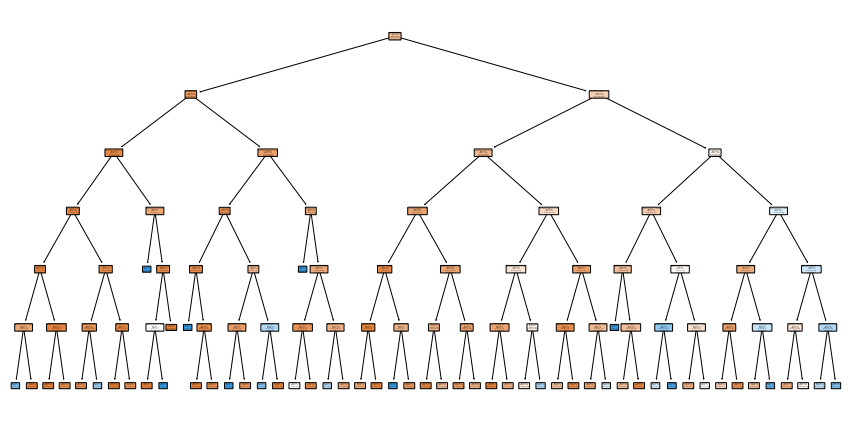

In [33]:
# Initialize tree with the newly found best values for alpha and max_depth
clf_dt_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0, max_depth=6)
clf_dt_pruned = clf_dt_pruned.fit(X, y)

# Visualising the tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, filled=True, rounded=True, class_names=["Non-default", "Default"], feature_names=df_completed_loans_imp[features].columns); 

**Observation:** this looks much better! 

---

# Question 5
**10 points**

Using the optimal DT you determined in the previous question, predict the outcome of the loans in `df_current_loans`. These are loans that were still on-going at the time the data was collected. How many will default according to your classifier? Is this a reasonable number that you would pitch to the team at http://www.prosper.com? Justify and explain.

## Answer

In [34]:
# Re-initialize unpruned DT classifier
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X, y)

# Prepare dataset from current loans
X_current = df_current_loans[features]

# predict defaults with the pruned DT classifier
y_pred_pruned = clf_dt_pruned.predict(X_current)

# predict defaults with the unpruned DT classifier
y_pred = clf_dt.predict(X_current)

In [35]:
sum(y_pred) / len(y_pred)

0.1404050144648023

In [36]:
sum(y_pred_pruned) / len(y_pred)

0.045515911282545805

**Observation:** this is actually quite dissappointing. Our unpruned model will predict that 14.42% of the current loans will default, while our pruned model will predict that only 4.55%of the current loans will default. This seems unrealistic. A possible explanation would be that the current_loan dataset is significantly different from the completed_loan dataset.

In [37]:
clf_dt_pruned.feature_importances_

array([0.11549474, 0.03223474, 0.28092215, 0.0007422 , 0.01726536,
       0.39937258, 0.12371263, 0.00593727, 0.02431833])

**Observation:** according to our model the 3rd and 6th variables, `LoanMonthsSinceOrigination` and `BorrowerRate`, respectively, are the most predictive features. Let's check the distributions of these variables in particular between the completed and current loans dataset.

array([[<AxesSubplot:title={'center':'MonthlyLoanPayment'}>,
        <AxesSubplot:title={'center':'Term'}>,
        <AxesSubplot:title={'center':'LoanMonthsSinceOrigination'}>],
       [<AxesSubplot:title={'center':'InvestmentFromFriendsCount'}>,
        <AxesSubplot:title={'center':'Investors'}>,
        <AxesSubplot:title={'center':'BorrowerRate'}>],
       [<AxesSubplot:title={'center':'EstimatedEffectiveYield'}>,
        <AxesSubplot:title={'center':'EstimatedLoss'}>,
        <AxesSubplot:title={'center':'EstimatedReturn'}>]], dtype=object)

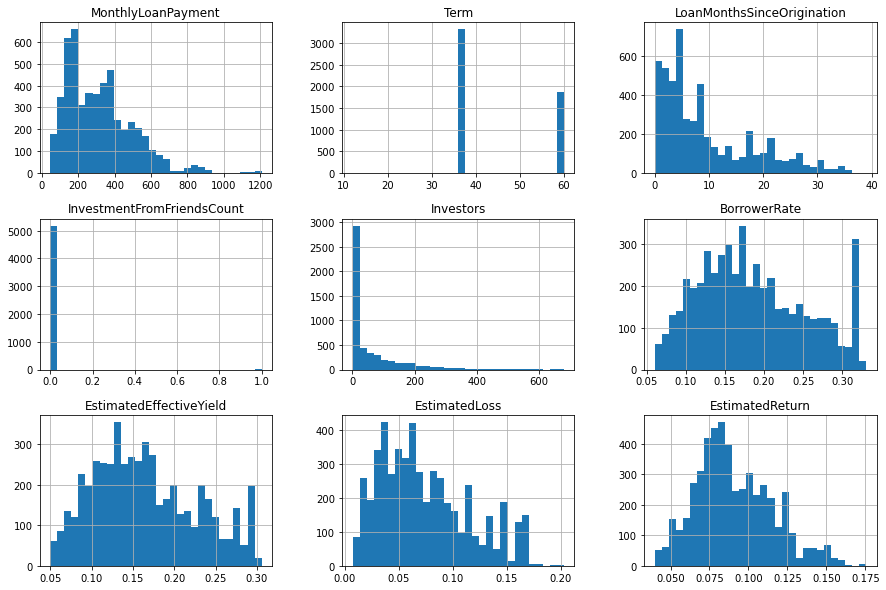

In [38]:
df_current_loans[features].hist(bins=30, figsize=(15, 10))

array([[<AxesSubplot:title={'center':'MonthlyLoanPayment'}>,
        <AxesSubplot:title={'center':'Term'}>,
        <AxesSubplot:title={'center':'LoanMonthsSinceOrigination'}>],
       [<AxesSubplot:title={'center':'InvestmentFromFriendsCount'}>,
        <AxesSubplot:title={'center':'Investors'}>,
        <AxesSubplot:title={'center':'BorrowerRate'}>],
       [<AxesSubplot:title={'center':'EstimatedEffectiveYield'}>,
        <AxesSubplot:title={'center':'EstimatedLoss'}>,
        <AxesSubplot:title={'center':'EstimatedReturn'}>]], dtype=object)

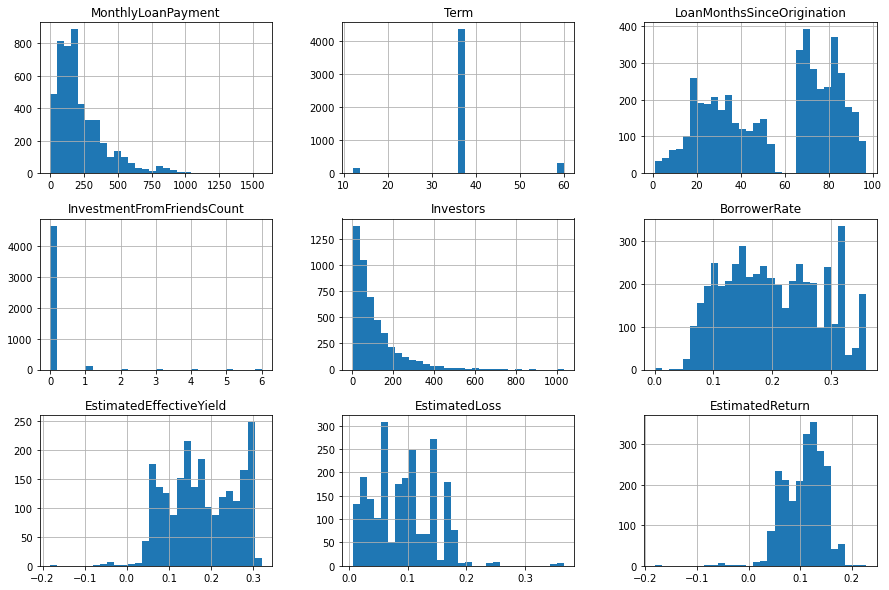

In [39]:
df_completed_loans[features].hist(bins=30, figsize=(15, 10))

**Interpretation:** in our predictive DT model, `LoanMonthsSinceOrigination` was one of the important predictors of default. However, in our current loans dataset, the distribution of this variable is much lower. Which makes sense, since completed loans have on average a higher value for time since origination. However, because of this difference in distribution, our prediction of defaults is most probably negatively biased. Meaning that probably there will be more defaults than the 4.74% that we predicted. 

---

# Question 6
**15 points**

We now turn to the `df_members`. 

**a)** For each member, calculate the average probability of defaulting (PD) on its loans. Store the results in a series called `sr_member_pd`. Use your predicted outcome from the previous question for loans that were still ongoing. What is the average default probability over all members?

**b)** Determine which `EmploymentStatus` is most likely to predict a high average probability of member default. Is this still a classification problem? Use `sklearn.tree.plot_tree` to plot your results.


**Hints** 
* Use the `members2loans` mapping you created in Question 1. 
* Hint Many variables in `df_members` are not numerical. How do you deal with this?

## Answer

**Part A)**

Member can have multiple loans! We can verify that by checking the count of unique MemberKeys and the count of total rows in the df_members list.

In [40]:
# number of rows in df
len(list(df_members.index))

10000

In [41]:
# number of unique MemberKeys
len(list(set(list(df_members.index))))

9750

In [42]:
member_keys = list(set(list(df_members.index)))

For each member, we calculate the average probability of defaulting (PD) on its loans.

In [43]:
# Initialize list to store average probabilities of default (PD)
sr_member_list = []
sr_member_prob_list = []

# Iterate over all members
for member_key in member_keys:
    
    # find all loan keys of the member
    loankey_list = list(members2loans[members2loans['MemberKey'] == member_key]['LoanKey'])
    
    # list to store probabilities of current loan(s)
    prob_list = []
    
    # find loans based on loan key list
    for loankey in loankey_list:
        
        # We only search in current loans, it does not make sense to compute prob of a completed loan
        loan = df_current_loans[df_current_loans.index == loankey]
        
        # If there is a current loan, calculate the probability of default 
        if loan.empty == False:
            probs = clf_dt_pruned.predict_proba(loan[features])[0][1]
            prob_list.append(probs)
    
    # Calculate average probability of default of a member if (s)he has at least one loan
    if len(prob_list) > 0:
        mean_prob = sum(prob_list) / len(prob_list)
    else:
        mean_prob = np.nan
    
    # append Memberkey to list
    sr_member_list.append(member_key)
    
    # append average probability to list
    sr_member_prob_list.append(mean_prob)

# Convert list to series as requested
sr_member_pd = pd.DataFrame.from_dict({'MemberKey': sr_member_list, 'Prob_default': sr_member_prob_list})

In [44]:
# Calculate average probability of default over all members
sr_member_pd['Prob_default'].mean()

0.1480886557433288

**Interpretation:** the average probability of defaults over all members is 14.81% (calculated over only the current loans). This values is significantly higher than the probability of default of 4.50% we calculated in the previous question. So our interpretation in the previous question was probably correct. The calculated value of 4.50% is most probably highly negatively biased due to differences in distribution of our most important predictive value.

**Part B)**

First, we search for the `EmploymentStatus` variable for every member in our dataset:

In [45]:
# iterate over all members and add their employment status
for key, row in sr_member_pd.iterrows():
    EmploymentStatus = df_members[df_members.index == row['MemberKey']]['EmploymentStatus'][0]
    sr_member_pd.loc[key,'EmploymentStatus'] = EmploymentStatus

We have a category for our predictive values (EmploymentStatus), and a continuous variable we would like to predict (probability of default). In this case, we apply our decision tree to a regression problems, using the DecisionTreeRegressor class. As in the classification setting, the fit method will take as argument arrays X and y, only that in this case y is expected to have floating point values instead of integer values.

In [46]:
# First, we remove nan values and apply one-hot encoding to our categorical variable
sr_member_pd_nona = sr_member_pd.dropna()
X = pd.get_dummies(sr_member_pd_nona['EmploymentStatus'], columns=['EmploymentStatus'])
y = sr_member_pd_nona['Prob_default']

In [47]:
# Initialise DT regressor model
clf_dtr = DecisionTreeRegressor()
clf_dtr = clf_dtr.fit(X, y)

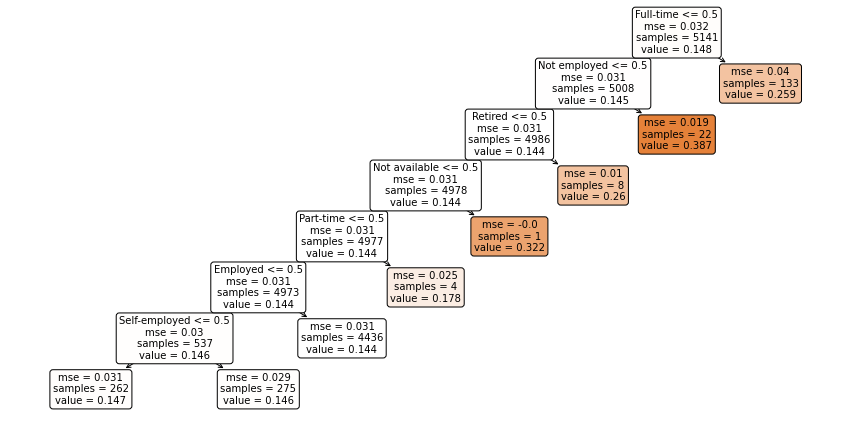

In [48]:
# Visualising the tree
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dtr, filled=True, rounded=True, class_names=["Non-default", "Default"], feature_names=X.columns); 

**Interpretation:**
- Someone who is full-time employed has an average predicted probability of default of 25.9%. 
- Someone who is not employed has an average predicted probability of default of 38.7%. Note, however, that in our dataset we only have 22 samples with this employment status, so be wary of the validity of this value.
- Someone who is retired has an average predicted probability of default of 26%. Note, however, that in our dataset we only have 8 samples with this employment status, so be wary of the validity of this value.
- Someone who is not available has an average predicted probability of default of 32.2%. Note, however, that in our dataset we only have 1 samples with this employment status, so be wary of the validity of this value.
- Someone who is working part-time has an average predicted probability of default of 17.8%. Note, however, that in our dataset we only have 4 samples with this employment status, so be wary of the validity of this value.
- Someone who is self-employed has an average predicted probability of default of 14.6%
- Someone who has a employment status of "other" has an average probability of default of 14.4%

\*These average probability of default values are based on our dataset with a decision tree regressor model (only current loans are considered).

---

# Question 7
**20 points**

You are paid handsomely as a consultant and are asked to describe the best and worst borrowers on Prosper. To make your presentation easier to follow, you give these two hypothetical members a name: Alex, who is the most likely to pay back on time, and Charlie, who is most likely to default. If you look at all the features in `df_members`, how would you characterize Alex and Charlie? Explain your thinking with the tools you learned. Visual aids are helpful.

**Step 1:** add variables to the sr_member_pd_nona set (set contains all members that have a current outstanding loan).

In [49]:
# Join the two tables together to add all variables
member_main = pd.merge(sr_member_pd_nona.set_index('MemberKey'), df_members, left_index=True, right_index=True)

# Drop duplicates after the join
member_main['index'] = member_main.index
member_main = member_main.drop_duplicates(subset=['index'])
member_main = member_main.drop(columns=['index'])

**Step 2:** check for missing values

In [50]:
# Generate an overview of all missing values per variable
member_main.isna().sum()

Prob_default                              0
EmploymentStatus_x                        0
BorrowerState                             1
Occupation                              126
EmploymentStatus_y                        0
EmploymentStatusDuration                  2
IsBorrowerHomeowner                       0
CurrentlyInGroup                          0
CurrentCreditLines                        1
OpenCreditLines                           1
TotalCreditLinespast7years                0
OpenRevolvingAccounts                     0
OpenRevolvingMonthlyPayment               0
InquiriesLast6Months                      0
TotalInquiries                            0
CurrentDelinquencies                      0
AmountDelinquent                          1
DelinquenciesLast7Years                   0
PublicRecordsLast10Years                  0
PublicRecordsLast12Months                 1
RevolvingCreditBalance                    1
BankcardUtilization                       1
AvailableBankcardCredit         

**Interpretation:** TotalProsperLoans, TotalProsperPaymentsBilled, OnTimeProsperPayments, ProsperPaymentsLessThanOneMonthLate, ProsperPaymentsOneMonthPlusLate, ProsperPrincipalBorrowed, ProsperPrincipalOutstanding, ScorexChangeAtTimeOfListing have too many missing values to be included in our model! They will be removed.

In [51]:
# Drop the variables with too many missing values
member_main = member_main.drop(columns=['TotalProsperLoans', 
                          'TotalProsperPaymentsBilled', 
                          'OnTimeProsperPayments', 
                          'ProsperPaymentsLessThanOneMonthLate', 
                          'ProsperPaymentsOneMonthPlusLate', 
                          'ProsperPrincipalBorrowed', 
                          'ProsperPrincipalOutstanding', 
                          'ScorexChangeAtTimeOfListing',
                          'EmploymentStatus_y']).dropna()

In [52]:
# Check again for missing values
member_main.isna().sum()

Prob_default                   0
EmploymentStatus_x             0
BorrowerState                  0
Occupation                     0
EmploymentStatusDuration       0
IsBorrowerHomeowner            0
CurrentlyInGroup               0
CurrentCreditLines             0
OpenCreditLines                0
TotalCreditLinespast7years     0
OpenRevolvingAccounts          0
OpenRevolvingMonthlyPayment    0
InquiriesLast6Months           0
TotalInquiries                 0
CurrentDelinquencies           0
AmountDelinquent               0
DelinquenciesLast7Years        0
PublicRecordsLast10Years       0
PublicRecordsLast12Months      0
RevolvingCreditBalance         0
BankcardUtilization            0
AvailableBankcardCredit        0
TotalTrades                    0
TradesOpenedLast6Months        0
DebtToIncomeRatio              0
IncomeRange                    0
IncomeVerifiable               0
StatedMonthlyIncome            0
Recommendations                0
dtype: int64

**Step 2:** check for categorical values that need to be one-hot encoded

In [53]:
# Look for object types, those are categorical variables that need to be one-hot encoded
member_main.dtypes

Prob_default                   float64
EmploymentStatus_x              object
BorrowerState                   object
Occupation                      object
EmploymentStatusDuration       float64
IsBorrowerHomeowner               bool
CurrentlyInGroup                  bool
CurrentCreditLines             float64
OpenCreditLines                float64
TotalCreditLinespast7years     float64
OpenRevolvingAccounts            int64
OpenRevolvingMonthlyPayment    float64
InquiriesLast6Months           float64
TotalInquiries                 float64
CurrentDelinquencies           float64
AmountDelinquent               float64
DelinquenciesLast7Years        float64
PublicRecordsLast10Years       float64
PublicRecordsLast12Months      float64
RevolvingCreditBalance         float64
BankcardUtilization            float64
AvailableBankcardCredit        float64
TotalTrades                    float64
TradesOpenedLast6Months        float64
DebtToIncomeRatio              float64
IncomeRange              

**Interpretation:** BorrowerState, Occupation, EmploymentStatus (already done), IsBorrowerHomeowner, CurrentlyInGroup, and IncomeRange need to be converted to dummies.

**Step 3:** Create X and y for model training

In [54]:
X = pd.get_dummies(member_main, columns=['BorrowerState', 
                                         'EmploymentStatus_x',
                                         'Occupation',
                                         'IsBorrowerHomeowner',
                                         'CurrentlyInGroup',
                                         'IncomeRange'])
X = X.drop(columns=['Prob_default'])

In [55]:
y = member_main['Prob_default']

**Step 4:** Train and fit the decision tree regressor model

We actually prune the tree by giving it a maximum depth of 4. There are more complex methodologies to prune, but for our pitch we want to make it as simple as possible: 4 main characteristics between Alex and Charlie seems to be sufficient. We do not need to tell every detail about their life, only the 4 most predictive variables seem enough 

In [56]:
# Initialize the DT regressor
clf_dtr2 = DecisionTreeRegressor(max_depth=4)
clf_dtr2 = clf_dtr2.fit(X, y)

**Step 5:** Visualise the decision tree model

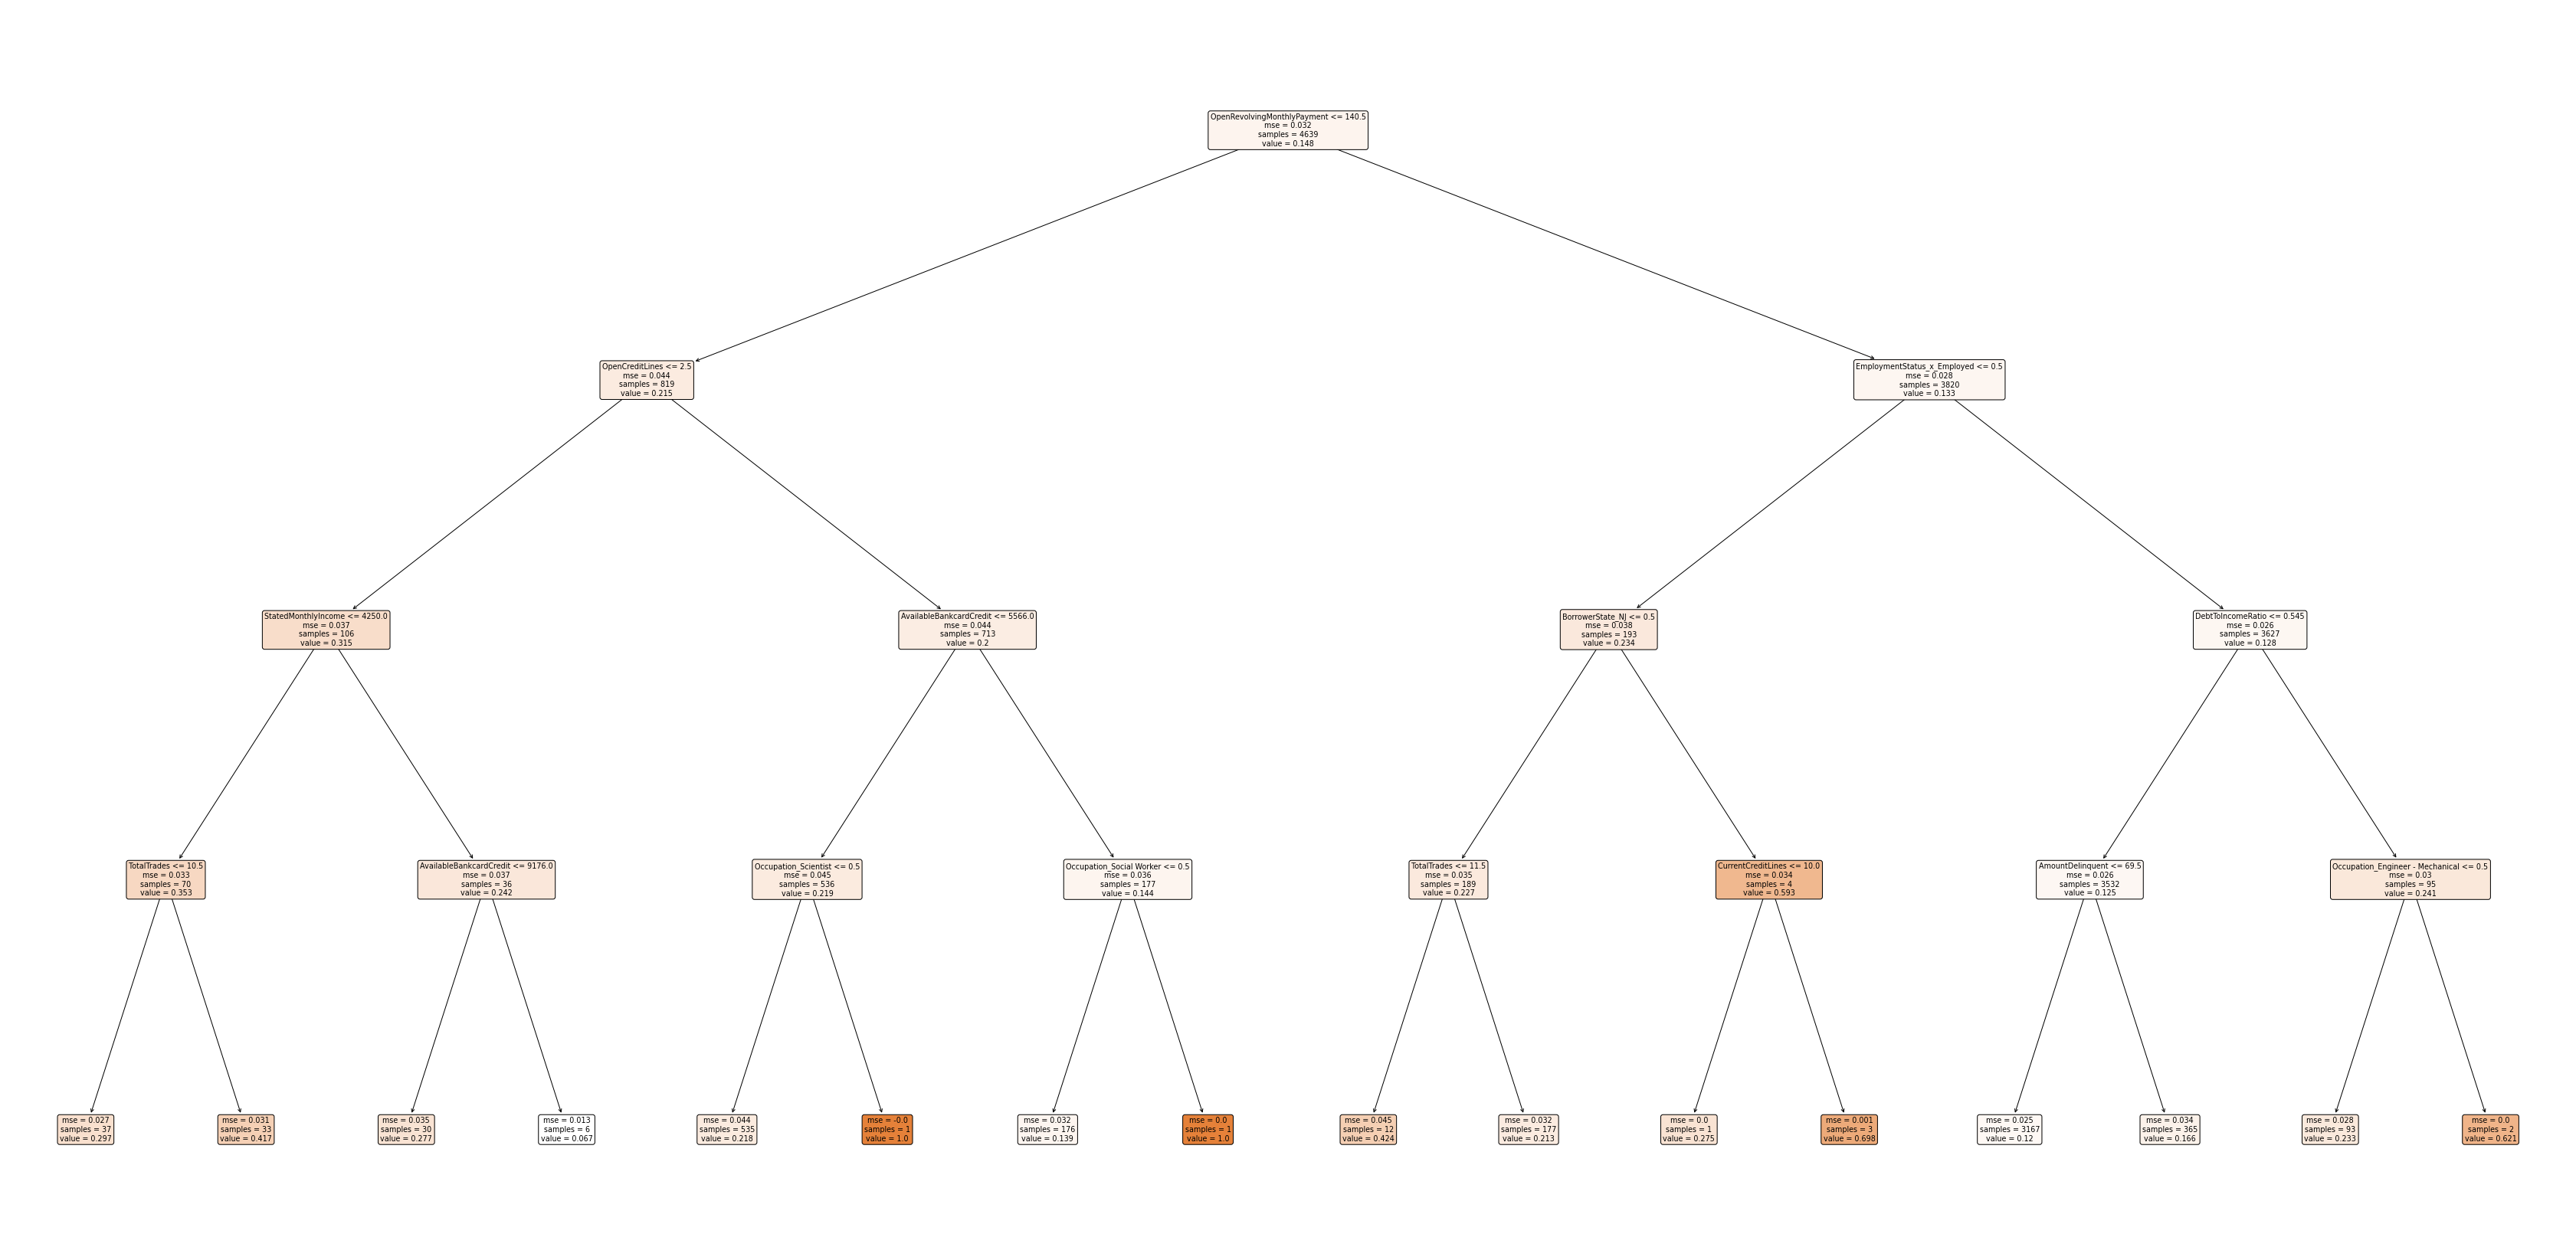

In [57]:
# Visualising the tree
plt.figure(figsize=(60, 30))
plot_tree(clf_dtr2, filled=True, rounded=True, class_names=["Non-default", "Default"], feature_names=X.columns);

*Note: this graph is very small in a Jupyter notebook, but you can right-click and download it to see it in high-res.*

**Step 6: interpretation**
   
   
From the visualised tree we can identify the following two individuals:

**Alex**, who is most likely to pay back on time, has an open revolving monthly payments of less than \\$140.5, has 2 or less open credit lines, a stated monthly income of \\$4250 or more, and has an available bankcard credit of \\$9176 or less 

**Charlier**, who is most likely to default is a scientist (ha! ha!), has three or more open credit lines, has a available bankcard credit of less than \\$5566, and has open revolving monthly payments of less than \\$140.50

---